In [14]:
import torch
mps_device = torch.device("mps")

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


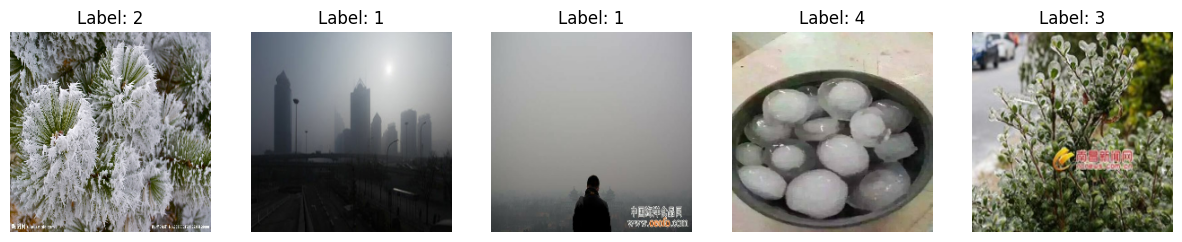

In [51]:
import tensorflow as tf
import pathlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
import tensorflow as tf
from keras.utils import to_categorical
import matplotlib.pyplot as plt


# Dataset/hyperparams
sandbox_dir = "../Data/Weather_Dataset"
batch_size = 32
image_size = (224, 224) #do not change for resnet50

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    sandbox_dir,
    labels='inferred',
    label_mode='int',
    validation_split=0.2,
    subset="both",
    seed=1234,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True
)

### USE THESE 
train_dataset, val_dataset = dataset 
 
class_names = train_dataset.class_names

# print first 5 of training set
for images, labels in train_dataset.take(1):
    fig, axes = plt.subplots(1, 5, figsize=(15, 5))
    for i in range(5):
        axes[i].imshow(images[i].numpy().astype("uint8"))
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].numpy()}")
    plt.show()
    break

In [52]:
# Convert the train dataset into two lists for images and labels
X_train, X_test, Y_train, Y_test = [], [], [], []

# Iterate through the batches
for images, labels in train_dataset:
    X_train.append(images)
    Y_train.append(labels)

# Iterate through the batches
for images, labels in val_dataset:
    X_test.append(images)
    Y_test.append(labels)

# Convert lists to TensorFlow tensors
X_train = tf.concat(X_train, axis=0)  # Combine batches into one tensor
Y_train = tf.concat(Y_train, axis=0)  # Combine labels into one tensor
X_test = tf.concat(X_test, axis=0)  # Combine batches into one tensor
Y_test = tf.concat(Y_test, axis=0)  # Combine labels into one tensor

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
print("X_test shape:", X_test.shape)
print("Y_test shape:", Y_test.shape)

2025-04-12 21:59:08.670277: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:59:11.914886: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:59:16.820915: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:59:21.051003: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-04-12 21:59:25.210372: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_train shape: (5490, 224, 224, 3)
Y_train shape: (5490,)
X_test shape: (1372, 224, 224, 3)
Y_test shape: (1372,)


Class Names: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']


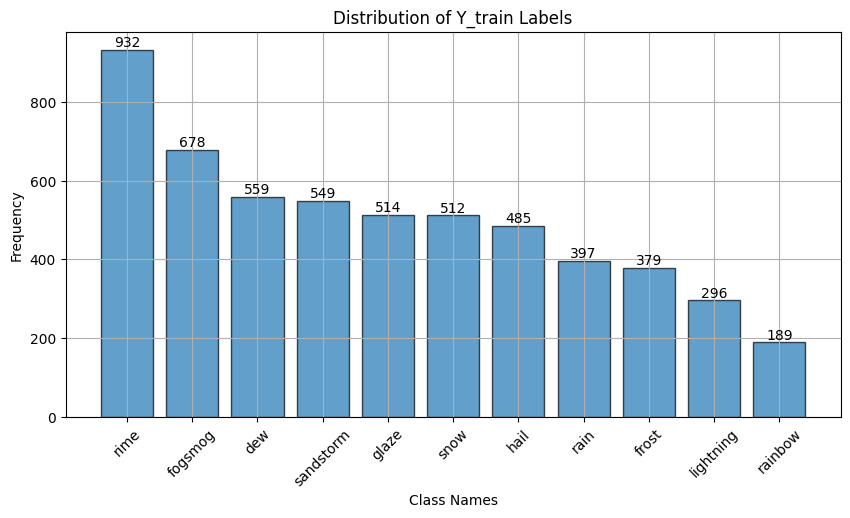

In [53]:
# Get class names from the dataset
class_names = train_dataset.class_names
print("Class Names:", class_names)

# Convert Tensor to NumPy array
Y_train_np = Y_train.numpy()

# Create a dictionary to map label indices to folder names
label_to_class = {i: class_names[i] for i in range(len(class_names))}

# Map labels to class names
Y_train_classes = [label_to_class[label] for label in Y_train_np]

# Count the frequency of each class
class_counts = {class_name: Y_train_classes.count(class_name) for class_name in class_names}

# Sort the class counts by frequency
sorted_class_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Plot the distribution with class names
plt.figure(figsize=(10, 5))
bars = plt.bar(sorted_class_counts.keys(), sorted_class_counts.values(), edgecolor='black', alpha=0.7)
plt.title("Distribution of Y_train Labels")
plt.xlabel("Class Names")
plt.ylabel("Frequency")
plt.grid(True)
plt.xticks(rotation=45)

# Label the frequencies on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom')

plt.show()

In [54]:
# Normalize the pixel values to [0, 1]
X_train = tf.cast(X_train, tf.float32) / 255.0
X_test = tf.cast(X_test, tf.float32) / 255.0

# Flatten the images using TensorFlow
X_train = tf.reshape(X_train, (tf.shape(X_train)[0], -1))
X_test = tf.reshape(X_test, (tf.shape(X_test)[0], -1))

# Print the shapes
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (5490, 150528)
X_test shape: (1372, 150528)


In [55]:
def build_model(num_features, learning_rate):
  """Build a TF logistic regression model using Keras.

  Args:
    num_features: The number of input features.
    learning_rate: The desired learning rate for SGD.

  Returns:
    model: A tf.keras model (graph).
  """
  # This is not strictly necessary, but each time you build a model, TF adds
  # new nodes (rather than overwriting), so the colab session can end up
  # storing lots of copies of the graph when you only care about the most
  # recent. Also, as there is some randomness built into training with SGD,
  # setting a random seed ensures that results are the same on each identical
  # training run.
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  # Build a model using keras.Sequential. While this is intended for neural
  # networks (which may have multiple layers), we want just a single layer for
  # binary logistic regression.
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(
      units=11,                     # output dim
      input_shape=[num_features],  # input dim
      use_bias=True,               # use a bias (intercept) param
      activation='softmax',     # softmax activation function for mutliclass classification
      kernel_initializer=tf.ones_initializer,  # initialize params to 1
      bias_initializer=tf.ones_initializer,    # initialize bias to 1
  ))

  # We need to choose an optimizer. We'll use SGD, which is actually mini-batch GD
  optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

  # Finally, compile the model. Select the accuracy metric. This finalizes the graph for training.
  model.compile(optimizer=optimizer, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['f1_score', 'auc', 'categorical_accuracy', 'precision', 'recall'])  # Categorical cross entropy (multiclass log loss)
  
  print(model.summary())

  return model

In [57]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def plot_history(model_history):
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(model_history.history['categorical_accuracy'], label='Train Accuracy')
    plt.plot(model_history.history['val_categorical_accuracy'], label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Model Training Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(model_history.history['loss'], label='Train Loss')
    plt.plot(model_history.history['val_loss'], label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Model Training Loss')
    plt.show()
    
def evaluate_model(model, X_val, y_val):
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val, y_val, verbose=0)

    # Extract metrics in the correct order
    val_loss = val_metrics[0]
    val_f1 = np.mean(val_metrics[1])
    val_auc = val_metrics[2]
    val_accuracy = val_metrics[3]
    val_precision = val_metrics[4]
    val_recall = np.mean(val_metrics[5])

    # Print the metrics
    print(f"""Validation Loss: {val_loss}, Validation F1 Score: {val_f1}, Validation AUC: {val_auc}, 
    Validation Accuracy: {val_accuracy}, Validation Precision: {val_precision}, Validation Recall: {val_recall}""")
    
    # Get model predictions
    Y_val_pred = model.predict(x=X_val)
    # Get the class with the highest probability for each sample
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    y_val_classes = np.argmax(y_val, axis=1)

    # Print classification report for subgroup accuracies
    print(classification_report(y_val_classes, Y_val_pred_classes, target_names=[str(label) for label in np.unique(y_val_classes)]))
    
    # Get confusion matrix
    conf_matrix=confusion_matrix(y_val_classes, Y_val_pred_classes)
    # Plot confusion matrix
    display = ConfusionMatrixDisplay(conf_matrix, display_labels=np.unique(y_val_classes))
    display.plot()
    plt.title("Validation Dataset Confusion Matrix")
    plt.yticks(fontsize=8)
    plt.xticks(fontsize=8, rotation=25)
    plt.show()

In [56]:
tf.random.set_seed(1234)
from keras.utils import to_categorical


Y_train_encoded = to_categorical(np.array(Y_train))
model= build_model(X_train.shape[1], learning_rate=0.0001)

model_history = model.fit(X_train, Y_train_encoded, validation_split=0.2, epochs=30, batch_size=32)

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 11)             │     1,655,819 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,655,819 (6.32 MB)

 Trainable params: 1,655,819 (6.32 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 23s 104ms/step - auc: 0.6966 - categorical_accuracy: 0.2584 - f1_score: 0.1660 - loss: 2.1567 - precision: 0.5397 - recall: 0.0083 - val_auc: 0.7669 - val_categorical_accuracy: 0.1849 - val_f1_score: 0.1440 - val_loss: 2.1507 - val_precision: 0.1327 - val_recall: 0.0474
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.8156 - categorical_accuracy: 0.4156 - f1_score: 0.2974 - loss: 1.8307 - precision: 0.7521 - recall: 0.0847 - val_auc: 0.7952 - val_categorical_accuracy: 0.2450 - val_f1_score: 0.2149 - val_loss: 2.0121 - val_precision: 0.2534 - val_recall: 0.1029
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - auc: 0.8406 - categorical_accuracy: 0.4511 - f1_score: 0.3456 - loss: 1.7190 - precision: 0.7863 - recall: 0.1488 - val_auc: 0.8109 - val_categorical_accuracy: 0.2823 - val_f1_score: 0.2482 - val_loss: 1.9382 - val_precision: 0.3266 - val_recall: 0.1466
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - auc: 0.8524

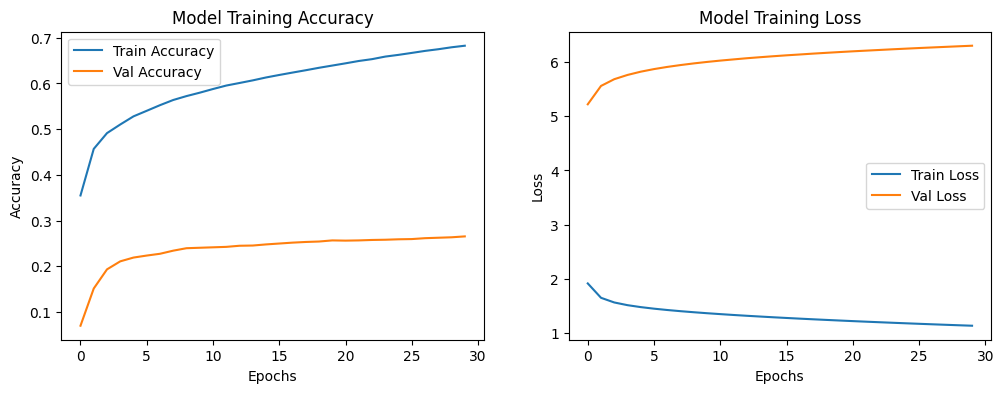

Validation Loss: 2.2985172271728516, Validation F1 Score: 0.44370585680007935, Validation AUC: 0.8241345286369324, 
    Validation Accuracy: 0.4883382022380829, Validation Precision: 0.7576923370361328, Validation Recall: 0.28717201948165894
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

              precision    recall  f1-score   support

           0       0.88      0.79      0.83       139
           1       0.52      0.62      0.56       173
           2       0.13      0.12      0.13        96
           3       0.48      0.36      0.41       125
           4       0.24      0.74      0.36       106
           5       0.52      0.79      0.63        81
           6       0.38      0.39      0.38       129
           7       0.32      0.28      0.30        43
           8       0.73      0.50      0.59       228
           9       0.88      0.55      0.68       143
          10       0.00      0.00      0.00       109

    accuracy                           0.49      1372
   macro avg       0.46      0.47      0.44      1372
weighted avg       0.52      0.49      0.48      1372



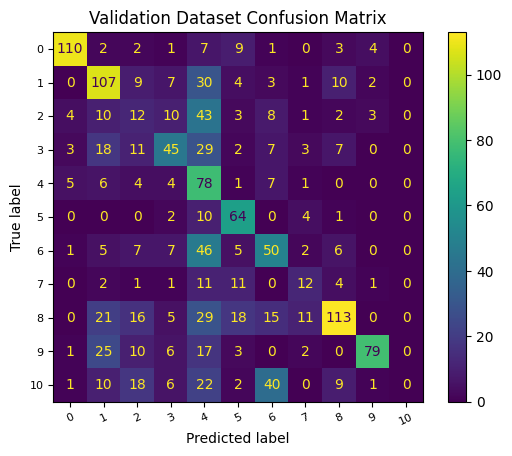

In [58]:
plot_history(model_history_oversampled)
evaluate_model(model_oversampled, X_val_oversampled, Y_val_encoded_oversampled)

# With 5-Fold Cross-Validation

In [174]:
# Convert TensorFlow tensors to NumPy arrays
X_train_np = X_train.numpy()
Y_train_np = Y_train.numpy()

# One-hot encode the labels
Y_train_encoded = to_categorical(Y_train_np)

# Define the number of folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize variables to store average metrics
avg_val_loss, avg_val_f1, avg_val_auc, avg_val_acc, avg_val_prec, avg_val_rec = 0, 0, 0, 0, 0, 0
all_true_labels, all_pred_labels = [], []

# Perform k-fold cross-validation
fold_no = 1
for train_index, val_index in kf.split(X_train_np):
    print(f"Training fold {fold_no}...")
    
    # Split data into training and validation sets for this fold
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    Y_train_fold, Y_val_fold = Y_train_encoded[train_index], Y_train_encoded[val_index]
    
    # Build and train the model
    model = build_model(X_train_fold.shape[1], learning_rate=0.0001)
    model.fit(X_train_fold, Y_train_fold, epochs=30, batch_size=32, validation_data=(X_val_fold, Y_val_fold))
    
    # Evaluate the model on the validation set
    val_metrics = model.evaluate(X_val_fold, Y_val_fold)
    print(f"Fold {fold_no} - Validation Metrics: {val_metrics}")
    
    val_loss, val_precision, val_recall, val_auc, val_accuracy = val_metrics[0], val_metrics[1], val_metrics[2], val_metrics[3], val_metrics[4]
    val_f1 = 2 * (val_precision * val_recall) / (val_precision + val_recall)
    
    print(f"Fold {fold_no} - Validation Loss: {val_loss}, Validation Precision: {val_precision}, Validation Recall: {val_recall}, Validation AUC: {val_auc}, Validation Accuracy: {val_accuracy}, Validation F1 Score: {val_f1}")
    
    # Predict the labels for the validation set
    Y_val_pred = model.predict(X_val_fold)
    Y_val_pred_classes = np.argmax(Y_val_pred, axis=1)
    Y_val_true_classes = np.argmax(Y_val_fold, axis=1)
    
    # Collect all true and predicted labels
    all_true_labels.extend(Y_val_true_classes)
    all_pred_labels.extend(Y_val_pred_classes)

    # Accumulate metrics
    avg_val_loss += val_loss
    avg_val_f1 += (2 * val_precision * val_recall) / (val_precision + val_recall)
    avg_val_auc += val_auc
    avg_val_acc += val_accuracy
    avg_val_prec += val_precision
    avg_val_rec += val_recall
    
    fold_no += 1

# Calculate the average validation metrics
avg_val_loss /= k
avg_val_auc /= k
avg_val_acc /= k
avg_val_rec /= k
avg_val_prec = np.mean(avg_val_prec)
avg_val_f1 = np.mean(avg_val_f1)

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {avg_val_f1}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {avg_val_prec}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Training fold 1...
Epoch 1/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - auc: 0.6919 - categorical_accuracy: 0.2563 - f1_score: 0.1673 - loss: 2.1630 - precision: 0.5434 - recall: 0.0113 - val_auc: 0.8160 - val_categorical_accuracy: 0.4080 - val_f1_score: 0.2702 - val_loss: 1.8919 - val_precision: 0.7705 - val_recall: 0.0428
Epoch 2/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - auc: 0.8181 - categorical_accuracy: 0.4167 - f1_score: 0.2981 - loss: 1.8291 - precision: 0.7478 - recall: 0.0833 - val_auc: 0.8342 - val_categorical_accuracy: 0.4381 - val_f1_score: 0.3357 - val_loss: 1.7839 - val_precision: 0.7500 - val_recall: 0.1011
Epoch 3/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - auc: 0.8416 - categorical_accuracy: 0.4500 - f1_score: 0.3390 - loss: 1.7203 - precision: 0.7732 - recall: 0.1428 - val_auc: 0.8401 - val_categorical_accuracy: 0.4572 - val_f1_score: 0.3660 - val_loss: 1.7354 - val_precision: 0.7430 - val_recall: 0.1448
Epoch 4/30
138/138 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step 

In [176]:

print(f"Average 5-Fold Cross Validation Loss: {avg_val_loss}")
print(f"Average 5-Fold Cross Validation F1 Score: {np.mean(avg_val_f1)}")
print(f"Average 5-Fold Cross Validation AUC: {avg_val_auc}")
print(f"Average 5-Fold Cross Validation Accuracy: {avg_val_acc}")
print(f"Average 5-Fold Cross Validation Precision: {np.mean(avg_val_prec)}")
print(f"Average 5-Fold Cross Validation Recall: {avg_val_rec}")

Average 5-Fold Cross Validation Loss: 1.536372447013855
Average 5-Fold Cross Validation F1 Score: 2.834247589111328
Average 5-Fold Cross Validation AUC: 0.5171220421791076
Average 5-Fold Cross Validation Accuracy: 0.738992428779602
Average 5-Fold Cross Validation Precision: 2.2925424575805664
Average 5-Fold Cross Validation Recall: 0.8716226816177368


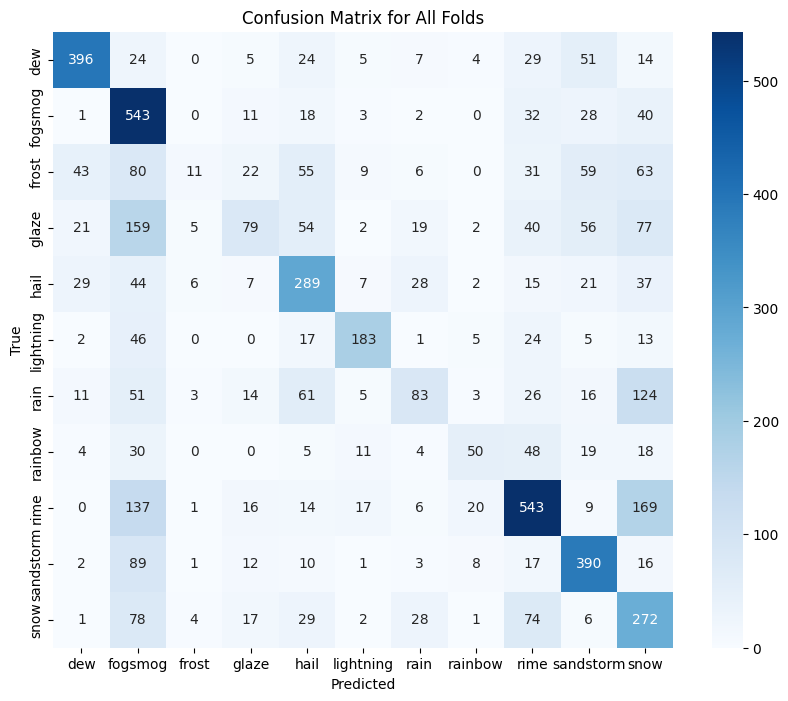

In [180]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix for all folds
cm = confusion_matrix(all_true_labels, all_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix for All Folds')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Logistic Regression with Balanced Oversampled Distribution

In [8]:
def load_data():
    # Dataset/hyperparams
    sandbox_dir = pathlib.Path("../Data/Weather_Dataset")
    batch_size = 8
    image_size = (224, 224)  # do not change for resnet50

    # Load dataset
    dataset = tf.keras.utils.image_dataset_from_directory(
        sandbox_dir,
        labels='inferred',
        label_mode='int',
        validation_split=0.2,
        subset="both",
        seed=1234,
        batch_size=batch_size,
        image_size=image_size,
        shuffle=True
    )

    ### USE THESE 
    train_dataset, val_dataset = dataset  

    # === Oversampling Preprocessing for the Training Dataset ===
    # Unbatch the training dataset to work with individual samples
    train_ds_unbatched = train_dataset.unbatch()

    # Retrieve class names and determine number of classes
    class_names = train_dataset.class_names
    num_classes = len(class_names)

    # Create a separate dataset for each class using filtering
    class_datasets = {}
    for i in range(num_classes):
        # Filter out samples that belong to class i
        class_datasets[i] = train_ds_unbatched.filter(lambda image, label: label == i)

    # Count samples per class
    counts = {}
    for i in range(num_classes):
        counts[i] = class_datasets[i].reduce(0, lambda x, _: x + 1).numpy()
    print("Original class counts:", counts)

    # Determine the maximum count among all classes
    max_count = max(counts.values())

    # Oversample each class: repeat and take exactly max_count samples for each
    oversampled_datasets = []
    for i in range(num_classes):
        ds = class_datasets[i].repeat().take(max_count)
        oversampled_datasets.append(ds)

    # Combine the oversampled datasets into one balanced dataset
    balanced_train_ds = oversampled_datasets[0]
    for ds in oversampled_datasets[1:]:
        balanced_train_ds = balanced_train_ds.concatenate(ds)

    # Shuffle and batch the balanced training dataset
    balanced_train_ds = balanced_train_ds.shuffle(buffer_size=1000).batch(batch_size)

    # Optionally, replace train_dataset with the balanced version
    train_dataset = balanced_train_ds

    # === Display a few samples from the balanced training dataset ===
    for images, labels in train_dataset.take(1):
        fig, axes = plt.subplots(1, 5, figsize=(15, 5))
        for i in range(5):
            axes[i].imshow(images[i].numpy().astype("uint8"))
            axes[i].axis("off")
            axes[i].set_title(f"Label: {labels[i].numpy()}")
        plt.show()
        break

    return train_dataset, val_dataset

In [9]:
def create_datasets(train_dataset, val_dataset):
    # Get X_val and y_val, normalize
    X_train, y_train = [], []
    for images, labels in train_dataset:
        X_train.append((images.numpy() / 255.0))
        y_train.append(labels.numpy())
    X_train = np.concatenate(X_train, axis=0)
    y_train = np.concatenate(y_train, axis=0)

    X_val, y_val = [], []
    for images, labels in val_dataset:
        X_val.append((images.numpy() / 255.0))
        y_val.append(labels.numpy())
    X_val = np.concatenate(X_val, axis=0)
    y_val = np.concatenate(y_val, axis=0)

    y_train = y_train.reshape(y_train.shape[0], 1)
    y_val = y_val.reshape(y_val.shape[0], 1)

    return X_train, y_train, X_val, y_val

Found 6862 files belonging to 11 classes.
Using 5490 files for training.
Using 1372 files for validation.


2025-04-12 21:03:11.085927: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:12.784808: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:14.221464: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:16.996893: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:18.299775: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:19.810438: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:22.655197: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:23.942444: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:03:25.611638: W tensorflow/core/lib/png/png_io.cc:89] PNG 

Original class counts: {0: 559, 1: 678, 2: 379, 3: 514, 4: 485, 5: 296, 6: 397, 7: 189, 8: 932, 9: 549, 10: 512}


2025-04-12 21:04:12.029370: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:13.264026: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:14.955845: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:18.015226: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:19.802247: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:21.059112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:143: Filling up shuffle buffer (this may take a while): 883 of 1000
2025-04-12 21:04:22.179422: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


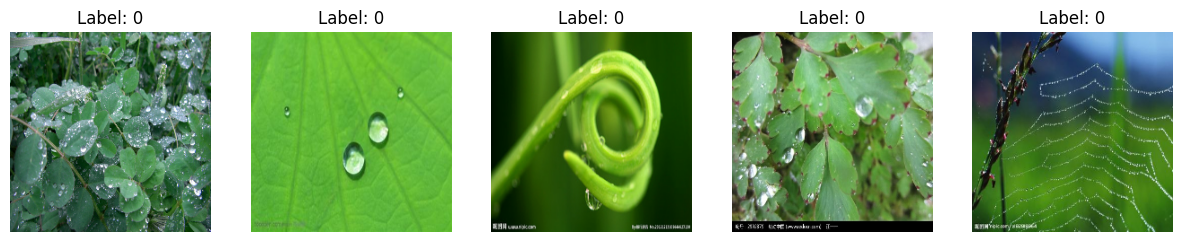

2025-04-12 21:04:23.826969: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:25.146746: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:27.215262: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:29.898741: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:31.529537: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:32.908677: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:143: Filling up shuffle buffer (this may take a while): 931 of 1000
2025-04-12 21:04:33.599565: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-04-12 21:04:33.852059: W tensorflow/core/lib/png/png_io.cc:89] PNG warning: iCCP: known incorrect sRGB profile
2025-04-12 21:04:36.3444

In [10]:
# Load Data and Create Datasets
train_dataset_oversampled, val_dataset_oversampled = load_data()
X_train_oversampled, y_train_oversampled, X_val_oversampled, y_val_oversampled = create_datasets(train_dataset_oversampled, val_dataset_oversampled)

In [35]:
# Flatten the images using TensorFlow
X_train_oversampled = tf.reshape(X_train_oversampled, (tf.shape(X_train_oversampled)[0], -1))
X_val_oversampled = tf.reshape(X_val_oversampled, (tf.shape(X_val_oversampled)[0], -1))


Y_train_encoded_oversampled = to_categorical(np.array(y_train_oversampled))
Y_val_encoded_oversampled = to_categorical(np.array(y_val_oversampled))

print(X_train_oversampled.shape)
print(y_train_oversampled.shape)
print(Y_train_encoded_oversampled.shape)
print(Y_val_encoded_oversampled.shape)

(10252, 150528)
(10252, 1)
(10252, 11)
(1372, 11)


In [36]:
tf.random.set_seed(1234)
from keras.utils import to_categorical


model_oversampled = build_model(X_train_oversampled.shape[1], learning_rate=0.0001)

model_history_oversampled = model_oversampled.fit(X_train_oversampled, Y_train_encoded_oversampled, validation_split = 0.2, epochs=30)

Epoch 1/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 35s 104ms/step - auc: 0.7488 - categorical_accuracy: 0.2879 - f1_score: 0.2260 - loss: 2.0612 - precision: 0.5160 - recall: 0.0083 - val_auc: 0.3614 - val_categorical_accuracy: 0.0697 - val_f1_score: 0.0663 - val_loss: 5.2188 - val_precision: 0.0602 - val_recall: 0.0024
Epoch 2/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - auc: 0.8607 - categorical_accuracy: 0.4564 - f1_score: 0.3684 - loss: 1.6657 - precision: 0.8585 - recall: 0.1113 - val_auc: 0.4227 - val_categorical_accuracy: 0.1511 - val_f1_score: 0.1196 - val_loss: 5.5573 - val_precision: 0.2143 - val_recall: 0.0234
Epoch 3/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - auc: 0.8758 - categorical_accuracy: 0.4978 - f1_score: 0.4252 - loss: 1.5648 - precision: 0.8281 - recall: 0.1696 - val_auc: 0.4461 - val_categorical_accuracy: 0.1931 - val_f1_score: 0.1472 - val_loss: 5.6814 - val_precision: 0.3170 - val_recall: 0.0536
Epoch 4/30
257/257 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - auc: 0.8839 -

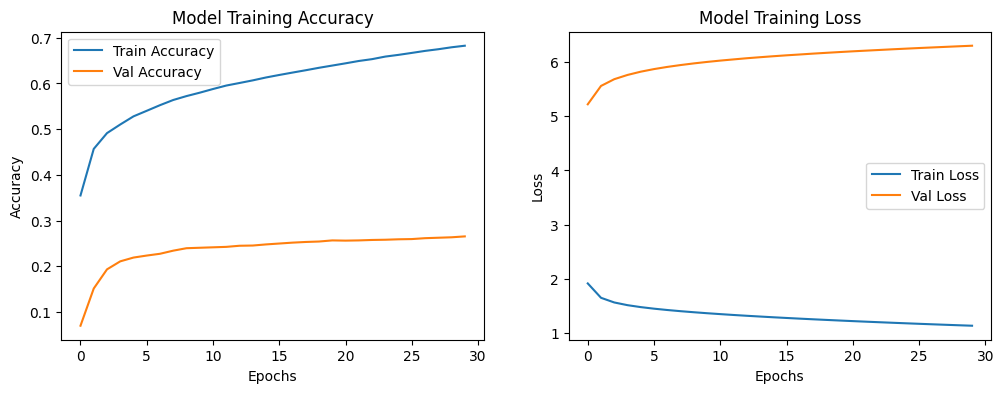

Validation Loss: 2.2985172271728516, Validation F1 Score: 0.44370585680007935, Validation AUC: 0.8241345286369324, 
    Validation Accuracy: 0.4883382022380829, Validation Precision: 0.7576923370361328, Validation Recall: 0.28717201948165894
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.88      0.79      0.83       139
           1       0.52      0.62      0.56       173
           2       0.13      0.12      0.13        96
           3       0.48      0.36      0.41       125
           4       0.24      0.74      0.36       106
           5       0.52      0.79      0.63        81
           6       0.38      0.39      0.38       129
           7       0.32      0.28      0.30        43
           8       0.73      0.50      0.59       228
           9       0.88      0.55      0.68       143
          10       0.00      0.00      0.00       109

    accuracy                           0.49      1372
   macro avg  

/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/belladavies/.julia/conda/3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

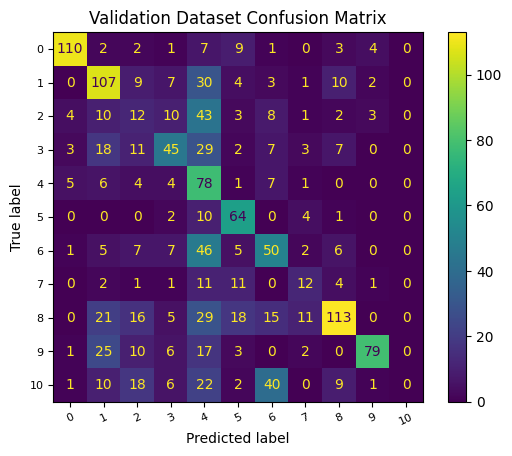

In [59]:
plot_history(model_history_oversampled)
evaluate_model(model_oversampled, X_val_oversampled, Y_val_encoded_oversampled)